### Config

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import gaussian_kde
import numpy as np
from scipy.stats import gaussian_kde
sns.set_theme(style="darkgrid")

path = "/raid/decaro/datasets/processed/AVLStudy2/"

# Stress Parameters

```python
    {
        4022: 0.08, 100
        4396: 0.15, 300
        1018: 0.08, 300
        4181: 0.20, 300
        4235: 1.00, 100
        4392: 1.25, 100
    }
```

# Stress Analysis

Events:
* Scenario 1: 92 to 132
* Scenario 2: 46 to 56 and 84 to 144
* Scenario 3: 32 to 52 and 60 to 90 and 103 to 123

In [7]:
def process_data(subj_id: str):
    data_path = os.path.join(
        path, f"SUBJ_{subj_id}", f"SUBJ_{subj_id}_ALL_SCENARIOS.csv"
    )
    data = pd.read_csv(data_path)[
        [
            "ScenarioID",
            "Maneuvre_ID",
            "Time",
            "EDA_Clean",
            "EDA_Phasic",
            "EDA_Tonic",
            "ECG_Clean",
            "ECG_Rate",
            "ECG_Raw",
            "Slider_value",
        ]
    ]
    data["Maneuvre_ID"] = data["Maneuvre_ID"].apply(
        lambda x: "Eco" if x == 1 else ("Comfort" if x == 2 else "Sport")
    )
    data["Slider_value"] /= 1024

    epsilon = 0.005
    for _, scenario_id in enumerate([1, 2, 3, 5, 4, 6, 8, 7, 9, 11, 10, 12]):
        data.loc[data["ScenarioID"] == scenario_id, "Slider_diff"] = (
            data.loc[data["ScenarioID"] == scenario_id, "Slider_value"]
            .diff()
            .rolling(10)
            .sum()
            .apply(lambda x: 1 if x > epsilon else (-1 if x < -epsilon else 0))
        )
        data.loc[data["ScenarioID"] == scenario_id, "events"] = data.loc[
            data["ScenarioID"] == scenario_id, "Time"
        ].apply(apply_events(scenario_id))
    data = data.dropna()
    return data[data["ScenarioID"] < 12], data[data["ScenarioID"] == 12]


def plot_densities(
    subj_id: str,
    coll_data: pd.DataFrame,
    validation_data: pd.DataFrame,
    save: bool = False,
):
    # coll_data = coll_data[coll_data["Slider_value"] > 0.1]
    # validation_data = validation_data[validation_data["Slider_value"] > 0.1]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    scenario_groups = [[3, 5, 4], [6, 8, 7], [9, 11, 10]]
    fig.suptitle(f"Subject {subj_id}")
    for i, scenario_group in enumerate(scenario_groups):
        scenario_data = coll_data[
            (coll_data["ScenarioID"] == scenario_group[0])
            | (coll_data["ScenarioID"] == scenario_group[1])
            | (coll_data["ScenarioID"] == scenario_group[2])
        ]
        driving_mode = scenario_data.iloc[0]["Maneuvre_ID"]
        sns.kdeplot(
            data=scenario_data,
            x="Slider_value",
            hue="Maneuvre_ID",
            ax=axes[i],
            common_norm=False,
            palette="colorblind",
        )
        axes[i].set_xlim((-0.15, 1.15))
        axes[i].set_title(f"Scenario {i+1}")
        axes[i].set_xlabel("Slider value")
        axes[i].get_legend().set_title("Driving mode")
        # coll_data.loc[coll_data["ScenarioID"] == scenario_id].iloc[500:].plot(
        #     x="Time",
        #     y=["Slider_value"],  # "EDA_Clean", "EDA_Tonic", "EDA_Phasic"],
        #     ax=axes[i // 3, i % 3],
        #     title=f"Scenario {scenario_id}",
        #     ylim=(-0.1, 1.1),

    sns.kdeplot(
        data=validation_data.iloc[500:],
        x="Slider_value",
        ax=axes[3],
        palette="colorblind",
    )
    axes[3].set_xlim((-0.15, 1.15))
    axes[3].set_title(f"Validation Scenario")
    axes[3].legend(title="Driving mode", labels=["Adaptive"])
    if save:
        plt.savefig(
            f"density_plots/subj_{subj_id}_densities.png", bbox_inches="tight", dpi=300
        )


def plot_violins(
    subj_id: str,
    coll_data: pd.DataFrame,
    validation_data: pd.DataFrame,
    save: bool = False,
):
    fig, ax = plt.subplots(figsize=(10, 5))
    data = pd.concat(coll_data, validation_data)
    sns.violinplot(data=data, x="ScenarioID", y="Slider_value", bw=0.5, ax=ax)
    ax.set_title(f"Subject {subj_id}")
    ax.set_xlabel("Scenario ID")
    ax.set_ylabel("Slider value")
    if save:
        plt.savefig(
            f"violin_plots/subj_{subj_id}_violins.png", bbox_inches="tight", dpi=300
        )


def plot_boxes(
    subj_id: str,
    coll_data: pd.DataFrame,
    validation_data: pd.DataFrame,
    save: bool = False,
):
    fig, ax = plt.subplots(figsize=(10, 5))
    data = pd.concat(coll_data, validation_data)
    sns.boxplot(data=data, x="ScenarioID", y="Slider_value", ax=ax)
    ax.set_title(f"Subject {subj_id}")
    ax.set_xlabel("Scenario ID")
    ax.set_ylabel("Slider value")
    if save:
        plt.savefig(f"boxplots/subj_{subj_id}_boxes.png", bbox_inches="tight", dpi=300)

In [18]:

def apply_events(scenario_id: int):
    if scenario_id in [1, 2]:
        slack = 5
        event_times = [25, 64]
    if scenario_id in [3, 5, 4]:
        slack = 5
        event_times = [70, 92, 98]
    elif scenario_id in [6, 8, 7]:
        slack = 5
        event_times = [40] + list(range(70, 150, 10))
    elif scenario_id in [9, 11, 10]:
        slack = 10
        event_times = [43, 82, 113]
    elif scenario_id == 12:
        slack = 5
        event_times = [44, 71, 83, 109, 138, 181, 207, 313, 538, 660, 666, 682]
        #event_times = [83]

    def events(x):
        if any([x - slack < t < x + slack for t in event_times]):
            return 1
        else:
            return 0
    
    return events
        

In [14]:
coll_data["ScenarioID"].unique()

array([ 3,  5,  4,  6,  8,  7,  9, 11, 10,  1,  2])

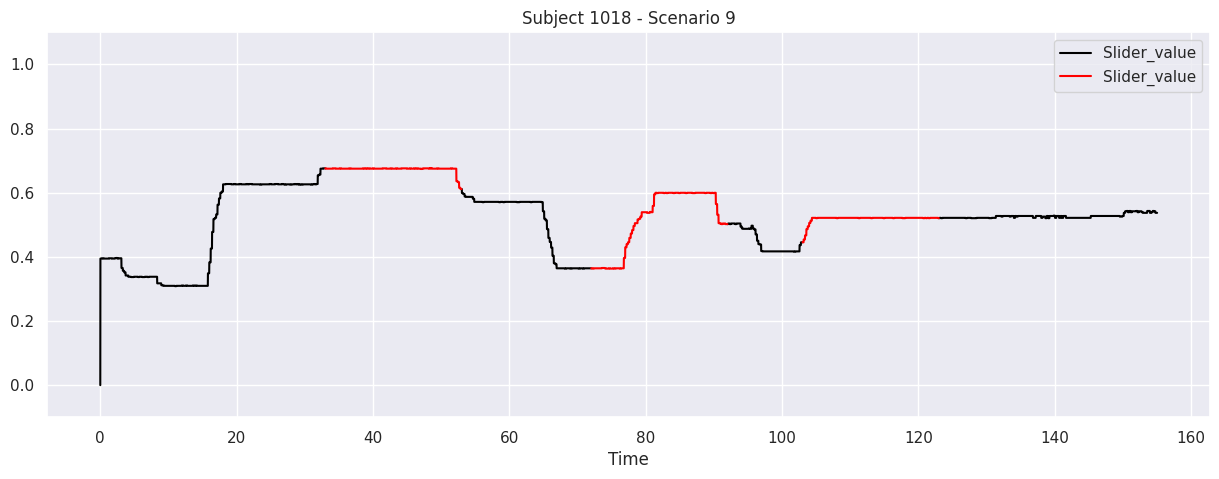

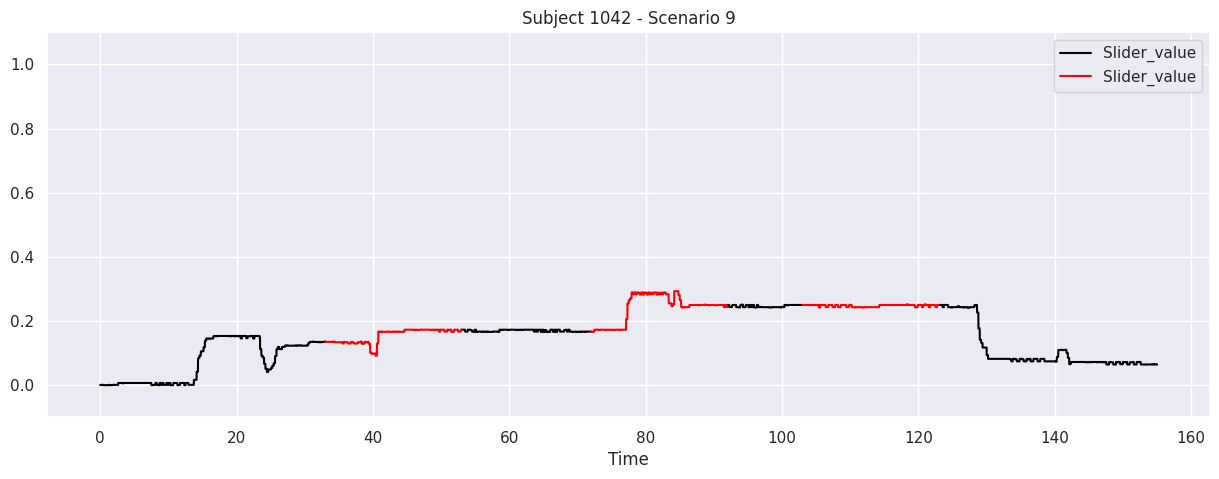

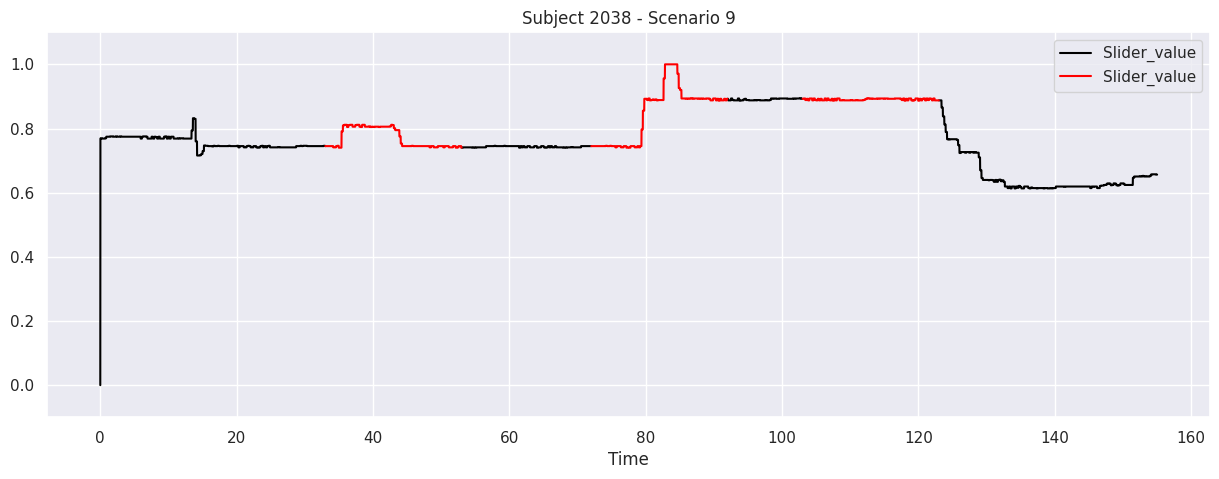

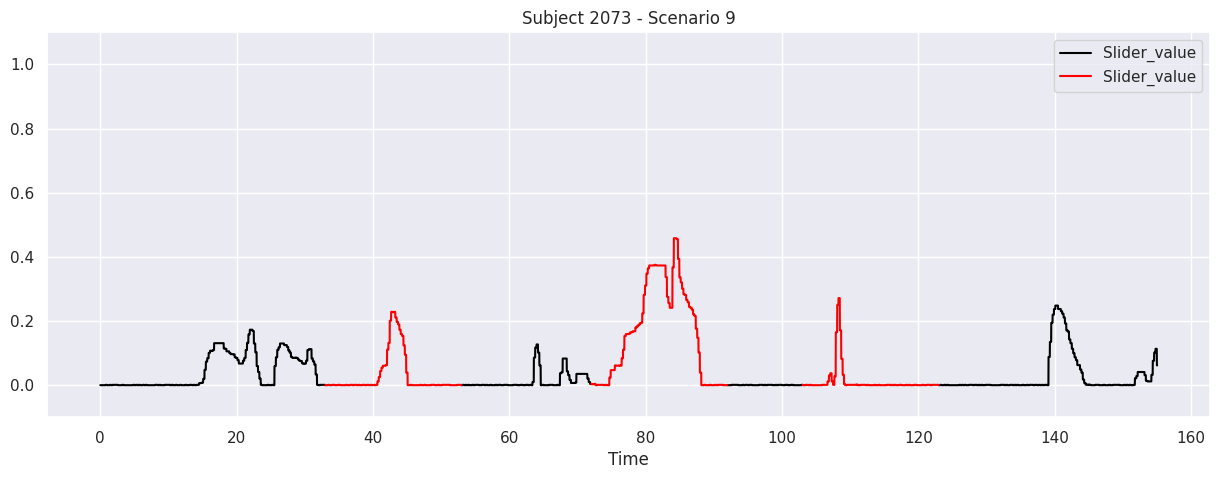

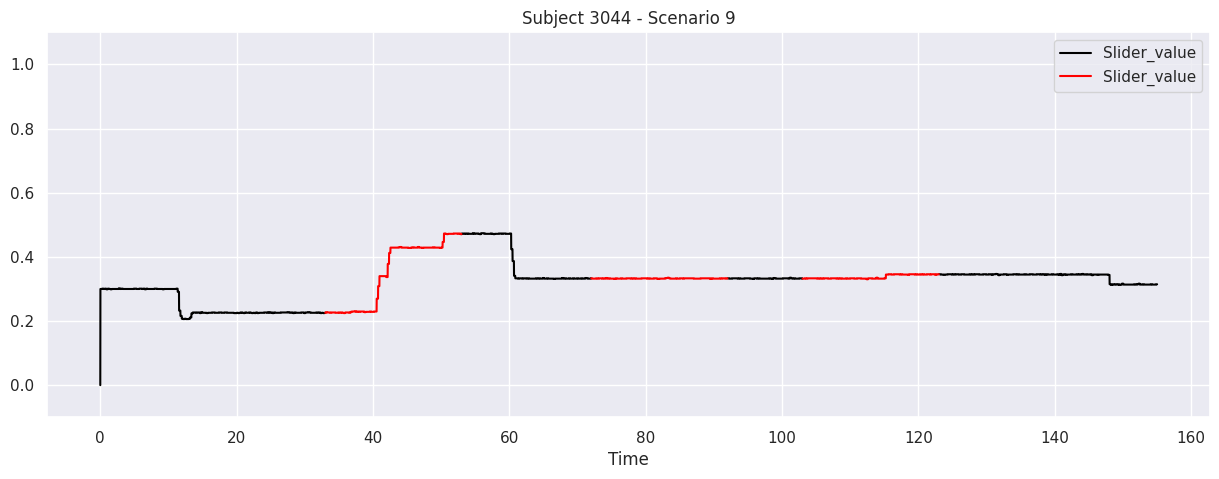

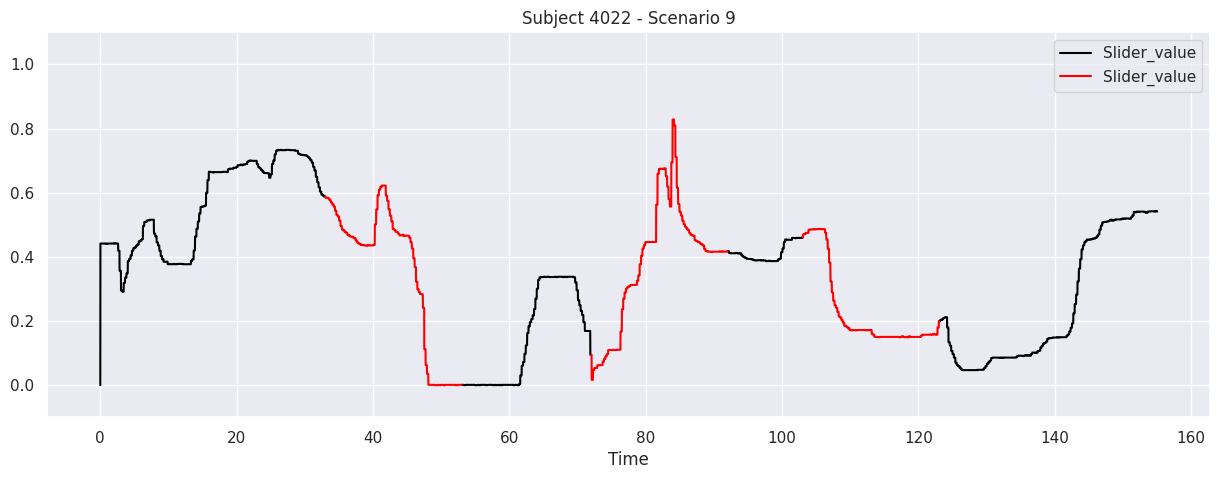

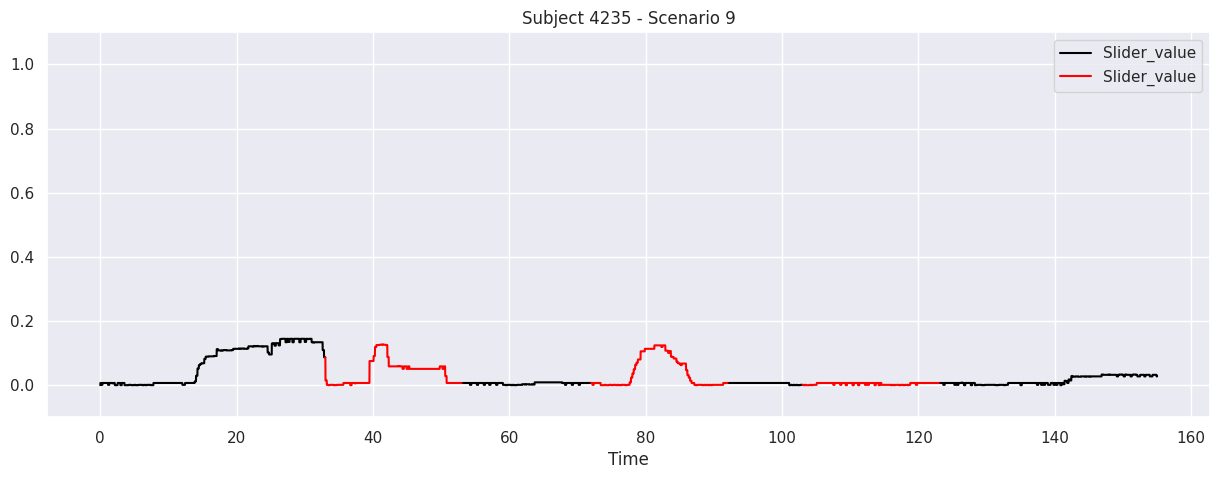

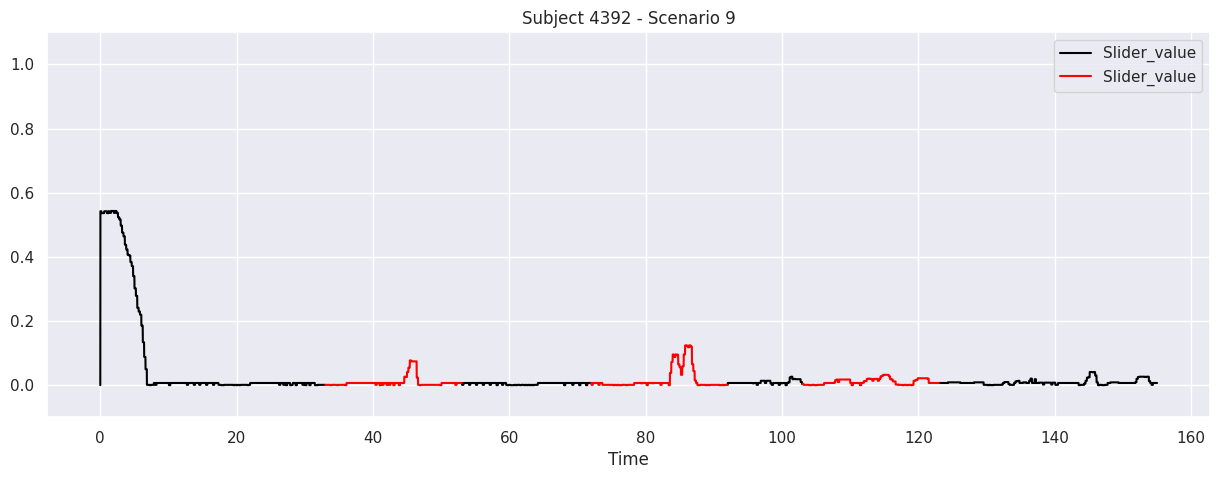

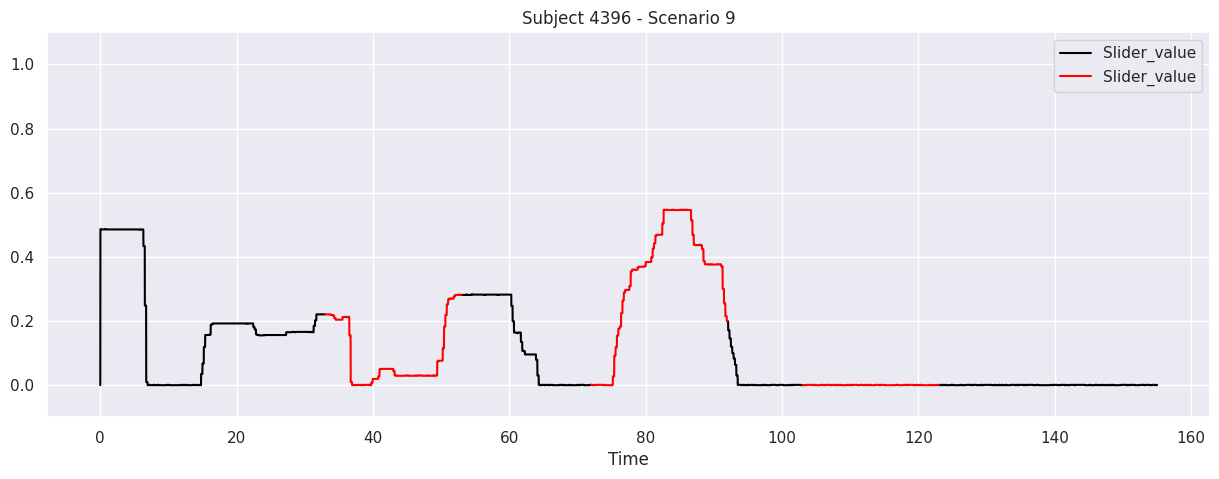

In [20]:
from copy import deepcopy

# sid = "1042"
for sid in ["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]:
    coll_data, validation_data = process_data(sid)
    for scenario_id in [9]: # [3, 5, 4, 6, 8, 7, 9, 11, 10]:
        fig, ax = plt.subplots(figsize=(15, 5))
        coll_data_s0 = deepcopy(coll_data)
        coll_data_s1 = deepcopy(coll_data)
        coll_data_s0.loc[(coll_data["ScenarioID"] == scenario_id) & (coll_data["events"] == 1), "Slider_value"] = np.nan
        coll_data_s1.loc[(coll_data["ScenarioID"] == scenario_id) & (coll_data["events"] == 0), "Slider_value"] = np.nan
        coll_data_s0[coll_data_s0["ScenarioID"] == scenario_id].plot(x="Time", y="Slider_value", color="black", ax=ax)
        coll_data_s1[coll_data_s1["ScenarioID"] == scenario_id].plot(x="Time", y="Slider_value", color="red", ax=ax)
        ax.set_title(f"Subject {sid} - Scenario {scenario_id}")
        ax.set_ylim((-0.1, 1.1))

    # fig, ax = plt.subplots(figsize=(15, 5))
    # val_data_0 = deepcopy(validation_data)
    # val_data_1 = deepcopy(validation_data)
    # val_data_0.loc[(validation_data["events"] == 1), "Slider_value"] = np.nan
    # val_data_1.loc[(validation_data["events"] == 0), "Slider_value"] = np.nan
    # val_data_0.plot(x="Time", y="Slider_value", ax=ax, color="black")
    # val_data_1.plot(x="Time", y="Slider_value", ax=ax, color="red")
    # ax.set_title(f"Subject {sid} - Validation")
    # ax.set_ylim((-0.1, 1.1))

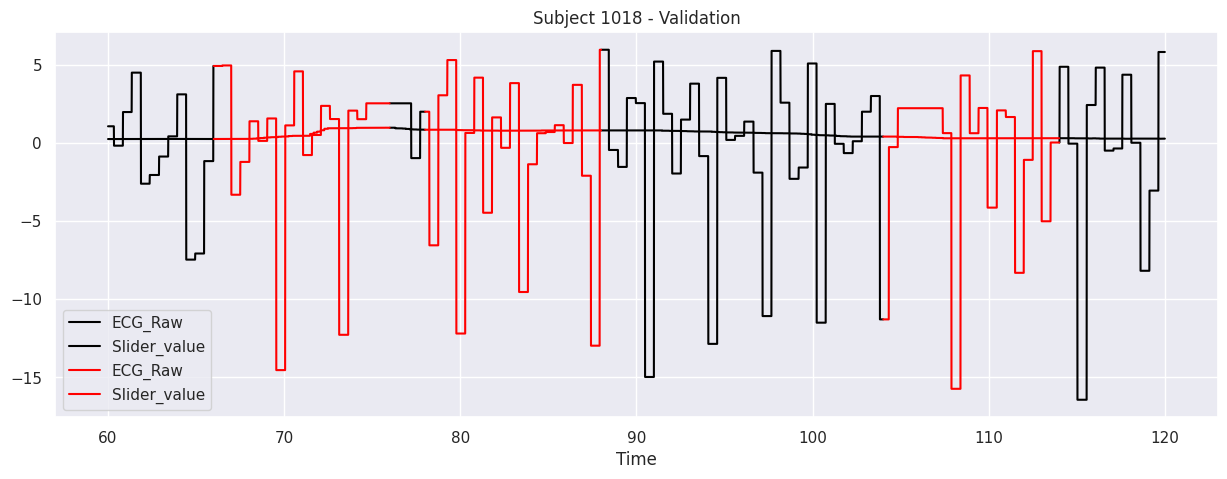

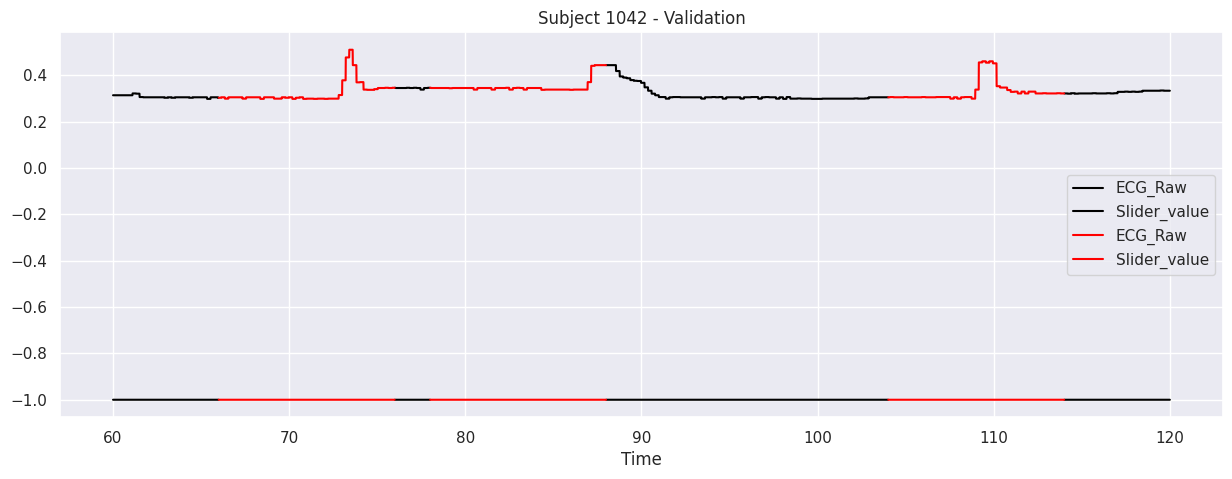

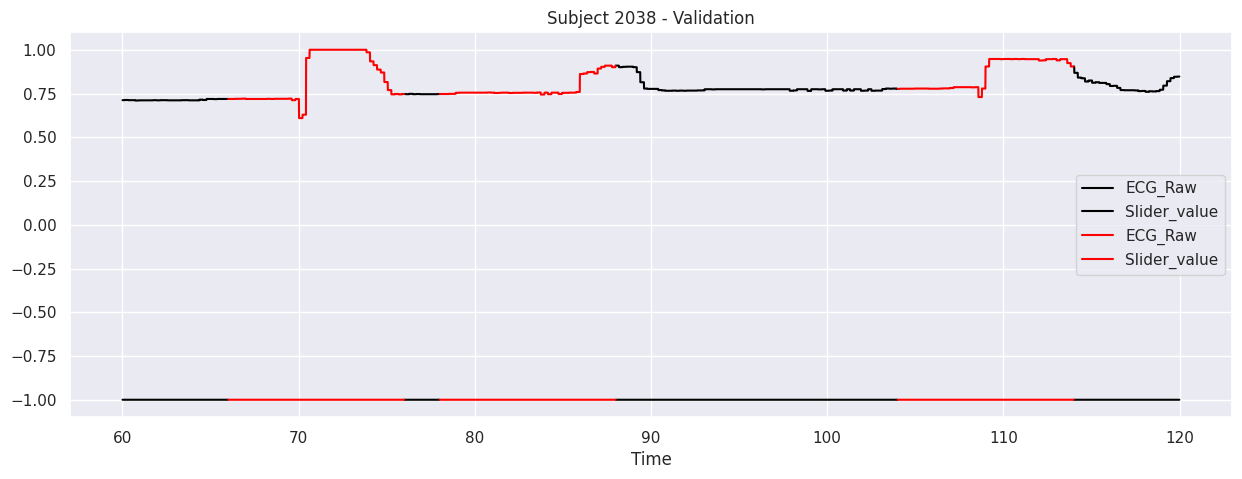

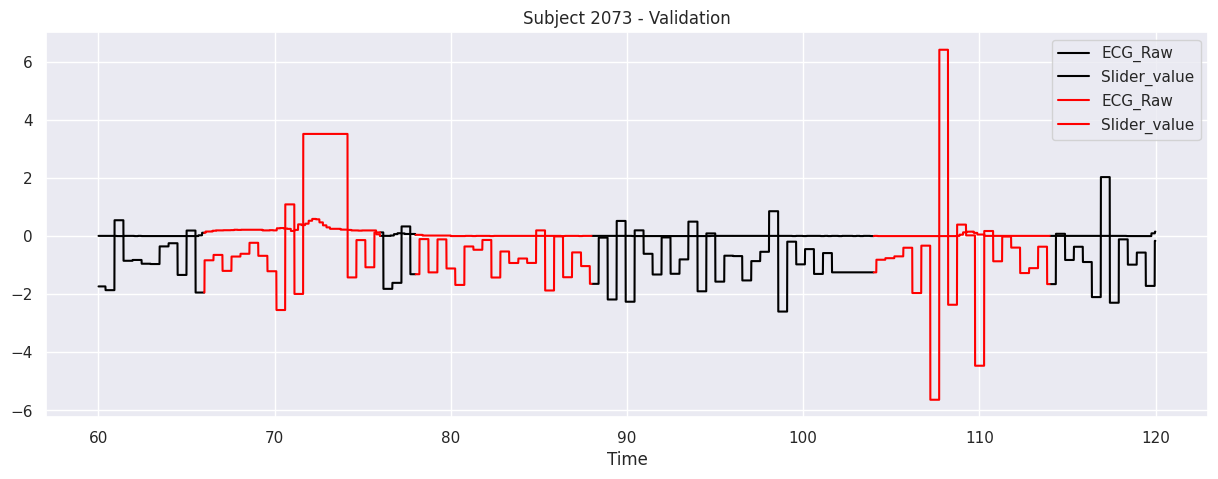

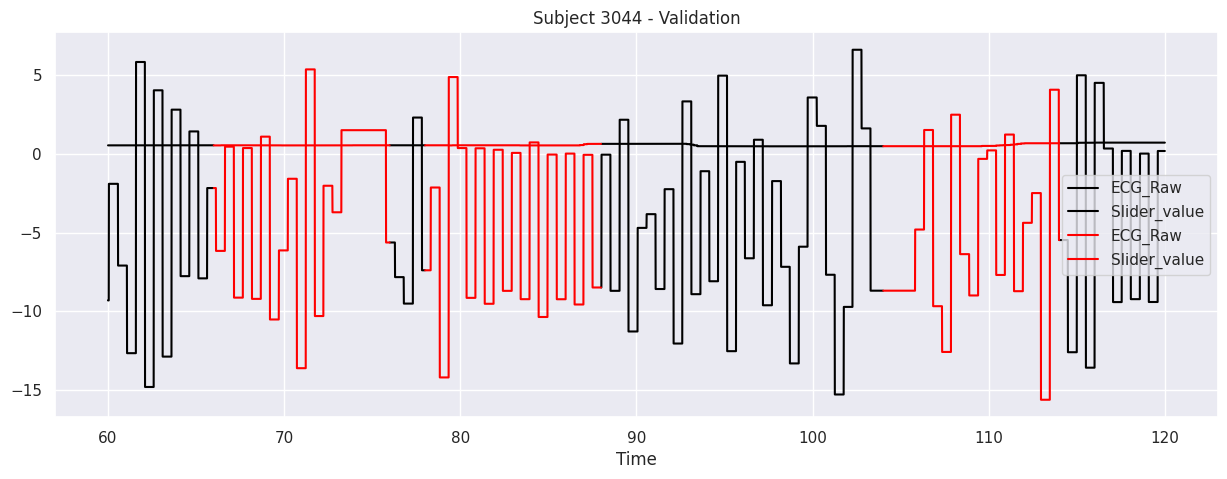

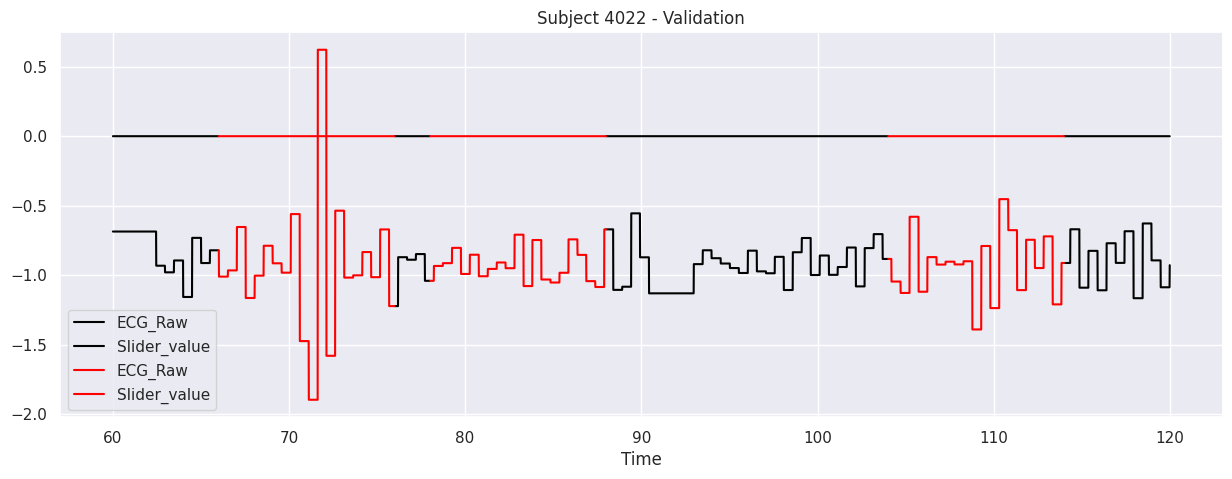

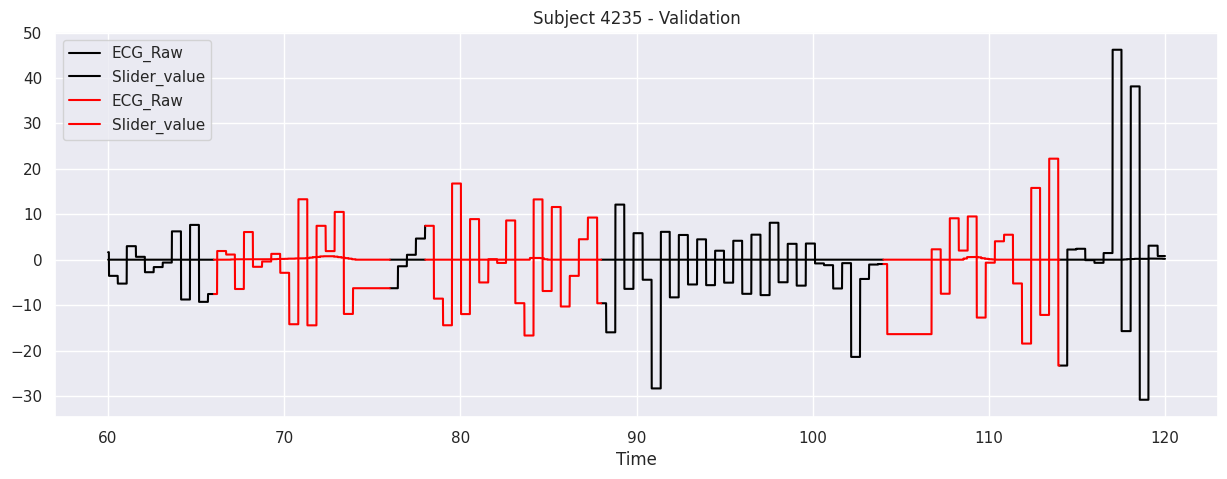

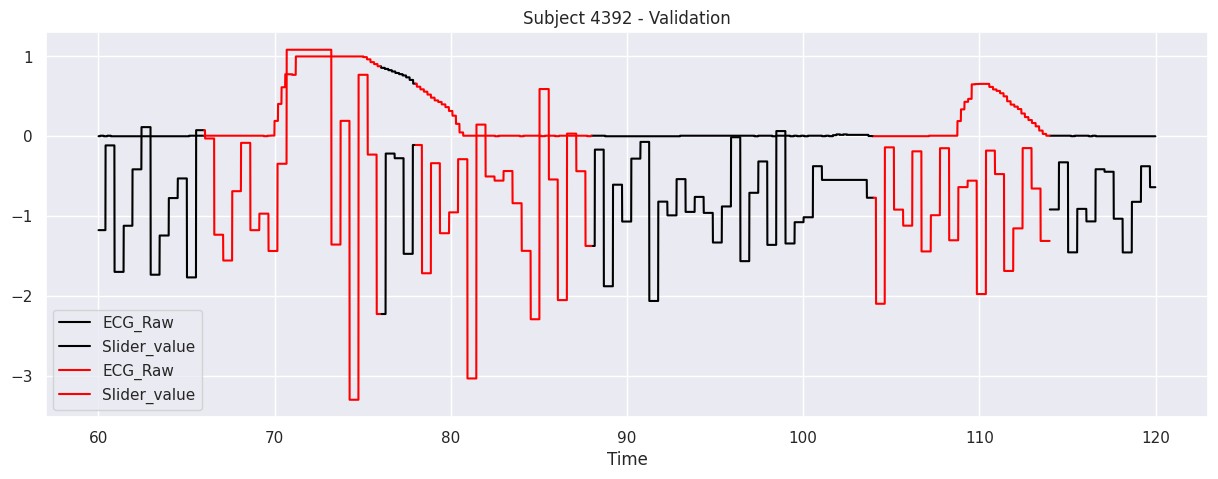

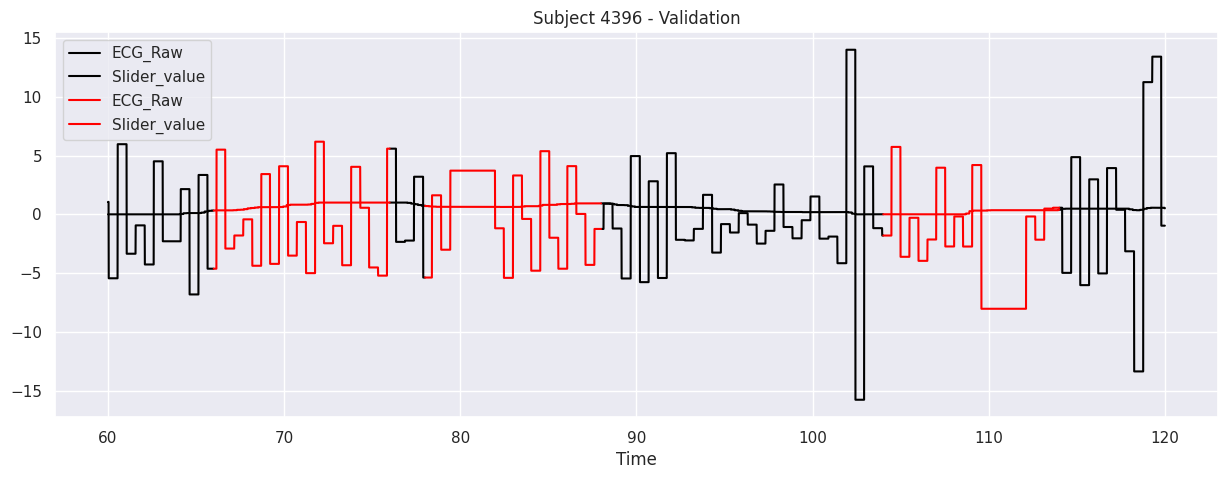

In [31]:
from copy import deepcopy

# sid = "1042"
for sid in ["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]:
    coll_data, validation_data = process_data(sid)
    # for scenario_id in [11]: # [3, 5, 4, 6, 8, 7, 9, 11, 10]:
    #     fig, ax = plt.subplots(figsize=(15, 5))
    #     coll_data_s0 = deepcopy(coll_data)
    #     coll_data_s1 = deepcopy(coll_data)
    #     coll_data_s0.loc[(coll_data["ScenarioID"] == scenario_id) & (coll_data["events"] == 1), "Slider_value"] = np.nan
    #     coll_data_s1.loc[(coll_data["ScenarioID"] == scenario_id) & (coll_data["events"] == 0), "Slider_value"] = np.nan
    #     coll_data_s0[coll_data_s0["ScenarioID"] == scenario_id].plot(x="Time", y="Slider_value", color="black", ax=ax)
    #     coll_data_s1[coll_data_s1["ScenarioID"] == scenario_id].plot(x="Time", y="Slider_value", color="red", ax=ax)
    #     ax.set_title(f"Subject {sid} - Scenario {scenario_id}")
    #     ax.set_ylim((-0.1, 1.1))
    field = ["ECG_Raw", "Slider_value"]
    fig, ax = plt.subplots(figsize=(15, 5))
    val_data_0 = deepcopy(validation_data)
    val_data_1 = deepcopy(validation_data)
    val_data_0.loc[(validation_data["events"] == 1), field] = np.nan
    val_data_1.loc[(validation_data["events"] == 0), field] = np.nan
    val_data_0[(val_data_0["Time"] > 60) & (val_data_0["Time"] < 120)].plot(x="Time", y=field, ax=ax, color="black")
    val_data_1[(val_data_1["Time"] > 60) & (val_data_1["Time"] < 120)].plot(x="Time", y=field, ax=ax, color="red")
    ax.set_title(f"Subject {sid} - Validation")
    # if field != "EDA_Phasic":
    #     ax.set_ylim((-0.5, 1.1))

In [ ]:
sid = "4396"
coll_data, validation_data = process_data(sid)
coll_data = coll_data[coll_data["Slider_value"] > 0.1]
validation_data = validation_data[validation_data["Slider_value"] > 0.1]
coll_density = gaussian_kde(coll_data["Slider_value"])
vl_density = gaussian_kde(validation_data["Slider_value"])
plot_densities(sid)

In [ ]:
print("Coll density integration: ", coll_density.integrate_box_1d(0, 1))
print("eval density integration: ", vl_density.integrate_box_1d(0, 1))

In [ ]:
slack = np.arange(0.1, 1, 0.1)
coll_density_slack = np.array([coll_density.integrate_box_1d(s, s+0.1) for s in slack])
vl_density_slack = np.array([vl_density.integrate_box_1d(s, s+0.1) for s in slack])
print("Coll density slack: ", coll_density_slack)
print("eval density slack: ", vl_density_slack)

In [ ]:
vl_density.pdf(np.arange(0.1, 1, 0.1)) - coll_density.pdf(np.arange(0.1, 1, 0.1))

In [ ]:
print(index)

In [ ]:
for subj_id in ["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]:
    plot_violins(subj_id)

In [ ]:
plot_boxes("4396")

In [ ]:
plot_densities("4396")

In [ ]:
for subj_id in ["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]:
    plot_densities(subj_id)

In [ ]:
fig, axes = plt.subplots(
    3, 3, figsize=(20, 10), sharex=True, sharey=True
)
for i, subject_id in enumerate(["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]):
    coll_data, validation_data = process_data(subject_id)
    coll_data = coll_data[coll_data["Slider_diff"] != 0]
    validation_data = validation_data[validation_data["Slider_diff"] != 0]
    # coll_data["Slider_diff"] = coll_data["Slider_diff"].astype(int)
    # validation_data["Slider_diff"] = validation_data["Slider_diff"].astype(int)
    sns.kdeplot(data=coll_data[coll_data["Slider_diff"] != 0], x="Slider_diff", common_norm=False, ax=axes[i // 3, i % 3])
    sns.kdeplot(data=validation_data[validation_data["Slider_diff"] != 0], x="Slider_diff", common_norm=False, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f"Subject {subject_id}")
    # Legend
    axes[i // 3, i % 3].legend(
        [
            "Collection",
            "Validation",
        ],
        loc="upper right",
    )
plt.savefig("slider_diff.png", dpi=300, bbox_inches="tight")

In [ ]:
prova = coll_data.groupby(["ScenarioID", "Slider_diff"]).count()
prova.rename(columns={"Time":"Count"}, inplace=True)
prova.columns

In [ ]:
def with_hue(plot, feature: pd.DataFrame, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts(sort=False).values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() + 0.15
            plot.annotate(percentage, (x, y), size = 12)

fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex="col")
for i, subject_id in enumerate(
    ["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]
):
    full_data = pd.concat(process_data(subject_id))
    full_data = full_data[full_data["Slider_diff"] != 0]
    full_data["ScenarioType"] = full_data["ScenarioID"].apply(
        lambda x: "Collection" if x < 12 else "Validation"
    )
    axes[i // 3, i % 3].set_title(f"Subject {subject_id}")
    cplot = sns.countplot(
        data=full_data,
        x="ScenarioType",
        hue="Slider_diff",
        ax=axes[i // 3, i % 3],
        palette="colorblind"
    )
    if i < 6:
        cplot.set_xlabel("")

    if i != 2:
        axes[i // 3, i % 3].get_legend().remove()
    else:
        # Set legend outside the plot
        axes[i // 3, i % 3].legend(
            title="Stress",
            labels=[
                "Down",
                "Up",
            ],
            loc="upper right",
        )
    axes[i // 3, i % 3].set_ylabel("Count")
    axes[i // 3, i % 3].set_ylim(0, max(full_data["ScenarioType"].value_counts().values) // 3 * 2 + 100)
    if subject_id != "4022":
        with_hue(axes[i // 3, i % 3], full_data["ScenarioType"], 2, 2)

In [ ]:
subj_id = "2038"
scenario_id = 1
dataset = AVLDataset(subj_id, "all",["EDA_Tonic", "EDA_Phasic"], "baseline", False)
df = dataset.features[dataset.features["ScenarioID"] == scenario_id]
# Compute differences with previous row
df["slider_diff"] = df["Slider_value"].diff()
df["slider_diff"].iloc[:2] = df["slider_diff"].iloc[2]
# Compute the rolling sum with a window size of 100
df["slider_diff_rolling_sum"] = df["slider_diff"].rolling(500).sum()
#df = df.iloc[500:]
def to_apply(x):
    if x["slider_diff_rolling_sum"] > 0.05:
        return 1
    elif x["slider_diff_rolling_sum"] < -0.05:
        return 0
    else:
        return np.NaN

df["stressing"] = df.apply(to_apply, axis=1)
df["stressing"].iloc[0] = 0
df["stressing"] = df["stressing"].fillna(method="ffill")

df.plot(x="Time", y=["Slider_value", "stressing", "slider_diff_rolling_sum"], figsize=(20, 10))

In [ ]:
columns = ["Subject"]
support = [f"Scenario_{i}" for i in range(3, 12)]
support += ["Eco", "Comfort", "Sport", "All", "Validation"]
for s in support:
    columns.append(s + "_mean")
    columns.append(s + "_std")
    if s != "Validation":
        columns.append(s + "_higher")

def get_mean_std_from_series(series, val_mean):
    mean = series.mean()
    std = series.std()
    if mean / val_mean > 1:
        better = 1
    else:
        better = 0
    return [mean, std, better]
stats_df = pd.DataFrame(columns=columns)
for subj_id in ["1018", "1042", "2038", "2073", "3044", "4022", "4235", "4392", "4396"]:
    cl, vl = process_data(subj_id)
    subj_values = [subj_id]
    val_mean, val_std = vl["Slider_value"].mean(), vl["Slider_value"].std()
    for i in range(3, 12):
        subj_values += get_mean_std_from_series(cl[cl["ScenarioID"] == i]["Slider_value"], val_mean)
    
    for i in ["Eco", "Comfort", "Sport"]:
        subj_values += get_mean_std_from_series(cl[cl["Maneuvre_ID"] == i]["Slider_value"], val_mean)
    
    subj_values += get_mean_std_from_series(cl["Slider_value"], val_mean)

    subj_values += [val_mean, val_std]
    stats_df.loc[len(stats_df)] = subj_values

stats_df

In [ ]:
stats_df.to_csv("stats.csv", index=False)

In [ ]:
stats_df.to_latex("stats.tex", index=False, float_format="%.3f")